In [10]:
ghosts_df = pd.read_csv("/kaggle/output/train.csv")
test_df    = pd.read_csv("/kaggle/output/test.csv")

ghosts_df.head()
#All data seems normalized. Should probably do the same for colors / types

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [11]:
ghosts_df.info()
print("--------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             371 non-null    int64  
 1   bone_length    371 non-null    float64
 2   rotting_flesh  371 non-null    float64
 3   hair_length    371 non-null    float64
 4   has_soul       371 non-null    float64
 5   color          371 non-null    object 
 6   type           371 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 20.4+ KB
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             529 non-null    int64  
 1   bone_length    529 non-null    float64
 2   rotting_flesh  529 non-null    float64
 3   hair_length    529 non-null    float64
 4   has_soul       529 non-null    float64
 5  

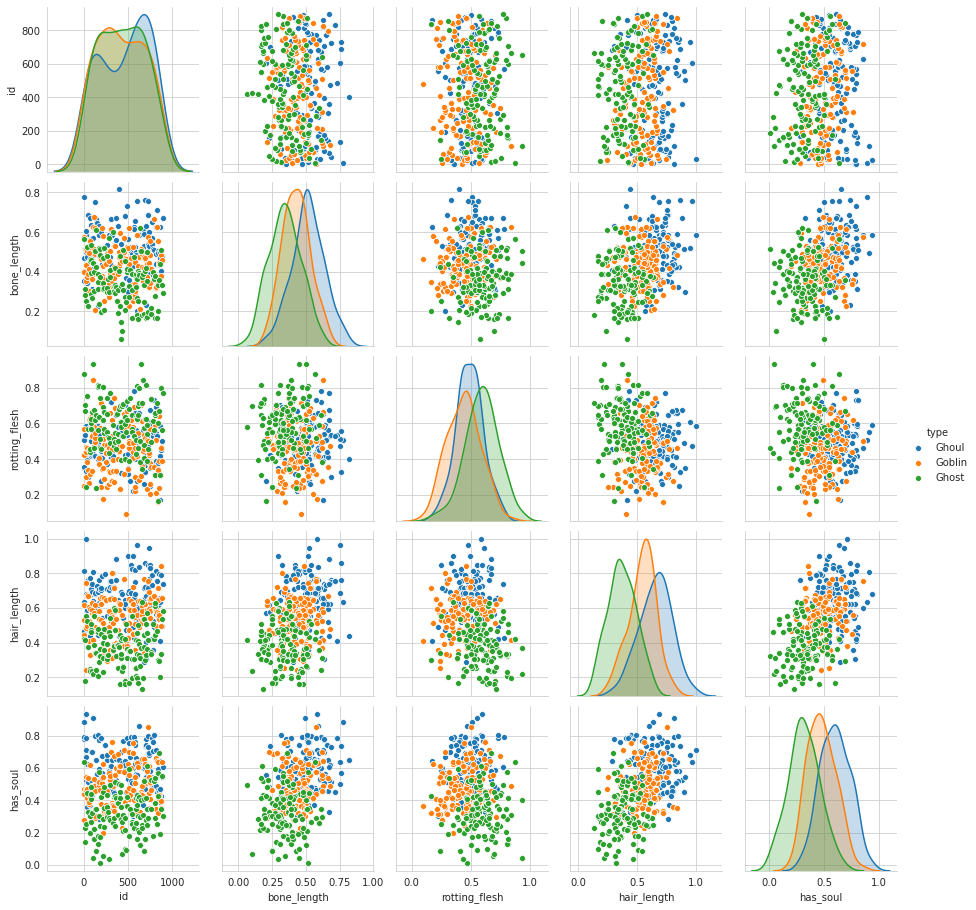

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

sns.pairplot(ghosts_df, hue="type")

In [13]:
ghosts_df = ghosts_df.drop("id",axis=1)
# convert string-values to floats for predicting on them
def remap_as_int(dataframe, indice, value, newValue):
    print("value={} reassigned to id={}".format(value, newValue))
    dataframe.loc[dataframe[indice] == value, indice] = newValue
    
def enumerate_list_unique(dataframe, indice):
    return list(enumerate(np.unique(dataframe[indice])))

monsters_list = enumerate_list_unique(ghosts_df, 'type')
monsters_list = [(0, 'Ghost'),(1, 'Ghoul'),(2, 'Goblin')]
print("All known types of monsters = {}".format(np.unique(ghosts_df['type'])))
for index, monster in monsters_list:
      remap_as_int(ghosts_df, 'type', monster, index)

#colors_list = enumerate_list_unique(ghosts_df, 'color')
colors_list = [(0, 'black'),(0.2, 'blood'),(0.4, 'blue'),(0.6, 'clear'),(0.8, 'green'),(1, 'white')]
print("All known colors of monsters = {}".format(np.unique(ghosts_df['color'])))
for index, color in colors_list:
      remap_as_int(ghosts_df, 'color', color, index)

All known types of monsters = ['Ghost' 'Ghoul' 'Goblin']
value=Ghost reassigned to id=0
value=Ghoul reassigned to id=1
value=Goblin reassigned to id=2
All known colors of monsters = ['black' 'blood' 'blue' 'clear' 'green' 'white']
value=black reassigned to id=0
value=blood reassigned to id=0.2
value=blue reassigned to id=0.4
value=clear reassigned to id=0.6
value=green reassigned to id=0.8
value=white reassigned to id=1


Candidates for feature engineering / combination:
* hair_length * has_soul
* hair_length * bone_length
* bone_length * has_soul

Ideas to proceed:
1. use only engineered features to train the model
2. add engineered features to dataframe and train on everything. Might confuse the model more than it helps?

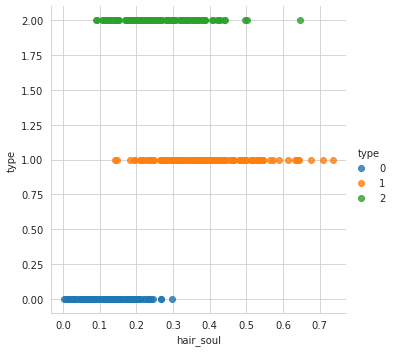

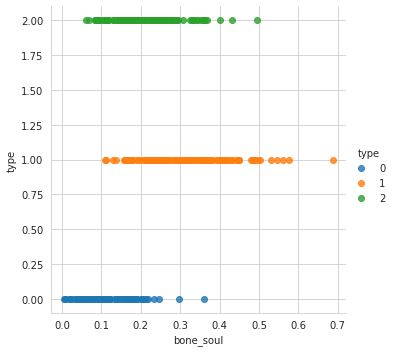

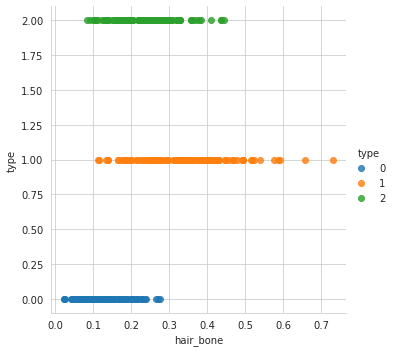

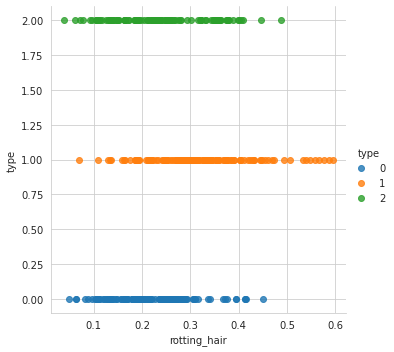

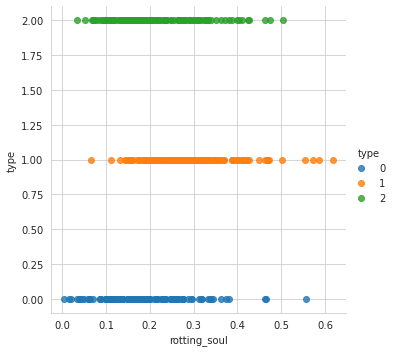

In [14]:
def create_features(dataframe):
    #Create some new variables.
    dataframe['hair_soul'] = dataframe['hair_length'] * dataframe['has_soul']
    dataframe['bone_soul'] = dataframe['bone_length'] * dataframe['has_soul']
    dataframe['hair_bone'] = dataframe['hair_length'] * dataframe['bone_length']
    dataframe['rotting_hair'] = dataframe['rotting_flesh'] * dataframe['hair_length']
    dataframe['rotting_soul'] = dataframe['rotting_flesh'] * dataframe['has_soul']
    
create_features(ghosts_df)

sns.lmplot("hair_soul", "type", data=ghosts_df, hue='type', fit_reg=False)
sns.lmplot("bone_soul", "type", data=ghosts_df, hue='type', fit_reg=False)
sns.lmplot("hair_bone", "type", data=ghosts_df, hue='type', fit_reg=False)
sns.lmplot("rotting_hair", "type", data=ghosts_df, hue='type', fit_reg=False)
sns.lmplot("rotting_soul", "type", data=ghosts_df, hue='type', fit_reg=False)

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


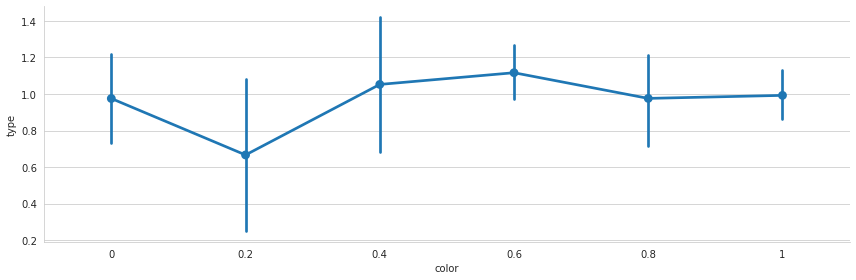

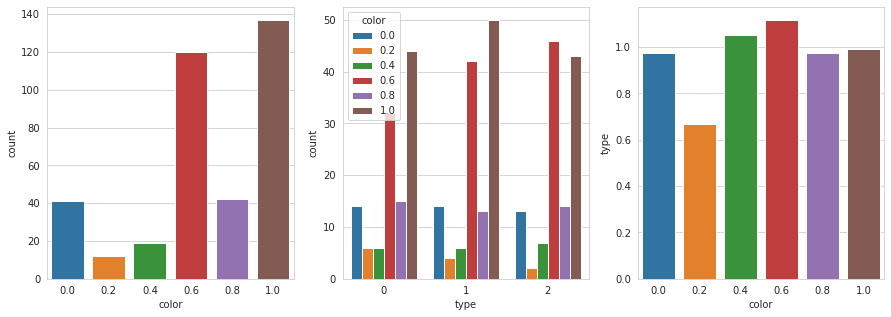

In [15]:
sns.factorplot('color','type', data=ghosts_df,size=4,aspect=3)

#Change types from object to int to compute on these indices
ghosts_df['type'] = ghosts_df['type'].astype(float)
ghosts_df['color'] = ghosts_df['color'].astype(float)

#It seems like color-distribution is fairly even across all types.
# However blood type is slightly higher for ghosts, and clear is more prominent for the other two.

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
sns.countplot(x='color', data=ghosts_df, ax=axis1)
sns.countplot(x='type', hue="color", data=ghosts_df, order=[monsters_list[0][0],monsters_list[1][0],monsters_list[2][0]], ax=axis2)

color_perc = ghosts_df[["color", "type"]].groupby(['color'],as_index=False).mean()
sns.barplot(x='color', y='type', data=color_perc, ax=axis3)